In [148]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import os

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


해당 프로젝트에 사용한 사진은 pixabay의 무료 저작권 이미지입니다.

1. 얼굴을 찾고 
2. 입술 중앙 위쪽 keypoint의 좌표를 이용하여 고양이 스티커를 붙입니다.

In [353]:
def temp(img_path):
    my_image_path = img_path
    img_bgr = cv2.imread(my_image_path)    # CV로 이미지 로드 
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

    print(' 이미지를 불러옵니다. ')

    plt.imshow(img_rgb) # plt에 이미지 올리고
    plt.show() # 이미지를 출력
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)

    print(' 얼굴을 찾습니다. ')

    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 5, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    model_path = 'shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    print(' keypoint를 찾습니다. ')
    
    list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    
    
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
            # 모든 landmark의 위치정보를 points 변수에 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_landmarks.append(list_points)
            # list_landmarks에 랜드마크 리스트를 저장

    if len(list_landmarks) == 0: # 랜드마크 못 찾았을 경우
        print(' keypoint 탐지 실패. ')
        return 0
    
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 5, (0, 255, 255), -1)
    
    # 찾은 랜드마크 시각화
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    print(' 고양이 스티커를 추가합니다. ')

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
        x = landmark[51][0] # 입술 위쪽 중앙의 x
        y = landmark[51][1] # 입술 위쪽 중앙의 y
        w = h = dlib_rect.width() # 얼굴의 너비, 높이
        
        sticker_path = 'cat_whiskers.png' # 고양이 스티커 경로
        img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
        img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지를 얼굴 크기 정도로 조정함
    
        # 고양이 수염이 들어가야될 이미지의 좌상단 좌표를 지정해줘야됨
        refined_x = x - w // 2
        refined_y = y - h // 2

        if refined_x < 0: # x 좌표가 음수이면
            img_sticker = img_sticker[:, -refined_x:] # 수염이 왼쪽으로 튀어나갔다는 뜻이므로 튀어나간 부분을 자름
            refined_x = 0

        if refined_y < 0: # y 좌표가 음수이면
            img_sticker = img_sticker[-refined_y:, :] # 수염이 위쪽으로 튀어나갔으므로 튀어나간 부분만큼 자름
            refined_y = 0 # y 좌표를 0으로 맞춘다. y좌표가 0인 지점이 이미지의 최상단이기 때문
        
        
        sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_sticker = img_sticker[:sticker_area.shape[0], :sticker_area.shape[1]] # 스티커 사진이 오른쪽으로 튀어나갈 수도 있으니까
        cat_area = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
        blend = cv2.addWeighted(sticker_area, 0.4, cat_area, 0.6, 0) # sticker랑 사진이랑 자연스럽게 블렌딩
        
        
        img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = blend
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()

 이미지를 불러옵니다. 


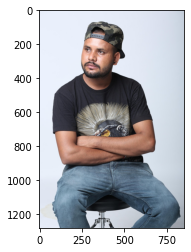

 얼굴을 찾습니다. 


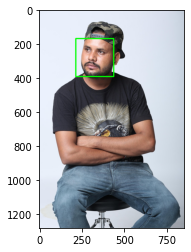

 keypoint를 찾습니다. 


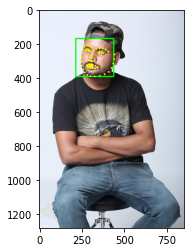

 고양이 스티커를 추가합니다. 


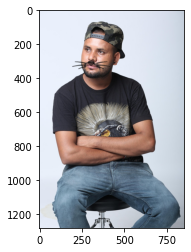

In [354]:
temp('man_1.jpg')

- 첫번째 남자의 경우 정상적으로 얼굴을 탐지하고 고양이 수염 스티커가 적용이 됨

 이미지를 불러옵니다. 


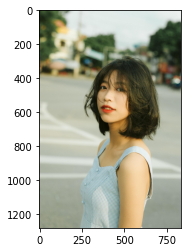

 얼굴을 찾습니다. 


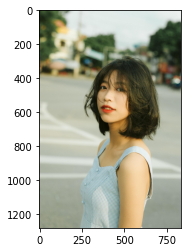

 keypoint를 찾습니다. 
 keypoint 탐지 실패. 


0

In [355]:
temp('woman_2.jpg')

- 얼굴 탐지 및 keypoint 탐지가 제대로 이루어지지 않는 경우 발생
  - 주변 배경에 영향을 받는 거 같음

 이미지를 불러옵니다. 


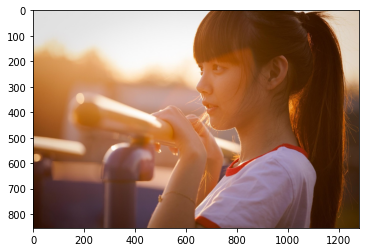

 얼굴을 찾습니다. 


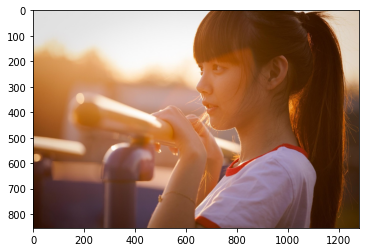

 keypoint를 찾습니다. 
 keypoint 탐지 실패. 


0

In [356]:
temp('woman_1.jpg')

- 얼굴 탐지 및 keypoint 탐지가 제대로 이루어지지 않는 경우 발생
  - 주변 배경에도 영향을 받고 옆모습은 탐지 못하는듯

 이미지를 불러옵니다. 


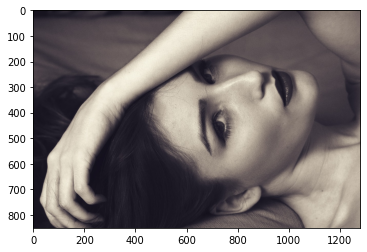

 얼굴을 찾습니다. 


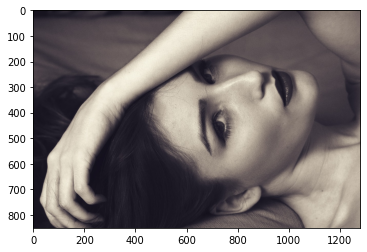

 keypoint를 찾습니다. 
 keypoint 탐지 실패. 


0

In [357]:
temp('woman_3.jpg')

- 누워있는 경우 얼굴이 제대로 탐지가 안 되고 keypoint도 제대로 탐지가 안 됨

 이미지를 불러옵니다. 


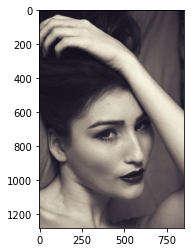

 얼굴을 찾습니다. 


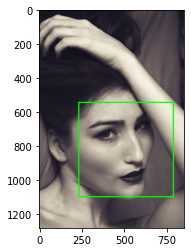

 keypoint를 찾습니다. 


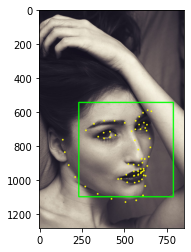

 고양이 스티커를 추가합니다. 


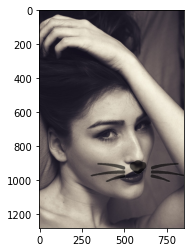

In [358]:
temp('woman_3_rotated.jpg')

- 얼굴 회전하니까 정상적으로 탐지됨

 이미지를 불러옵니다. 


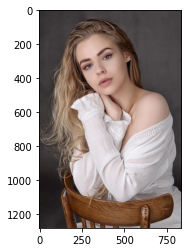

 얼굴을 찾습니다. 


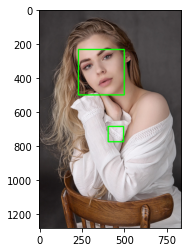

 keypoint를 찾습니다. 


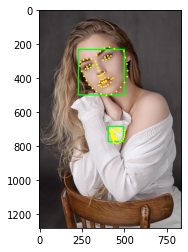

 고양이 스티커를 추가합니다. 


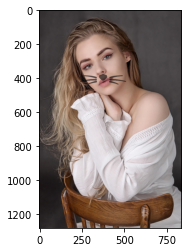

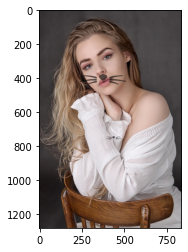

In [359]:
temp('woman_4.jpg')

- 얼굴을 2개로 잘못 탐지하여 고양이 스티커가 2개 들어가는 문제가 발생
- 얼굴의 각도가 기울어져 있는데 고양이 스티커는 그대로 들어가서 부자연스러움
  - 얼굴의 각도에 맞게 고양이 사진의 각도도 조절해줘야됨

## 결론
- 얼굴 탐지와 keypoint 탐지의 정확도가 중요함
  - 고양이 스티커 사진이 안 들어가는 문제가 발생함
  - 해당 코드에서 사용한 탐지기 같은경우 주변 환경에 영향을 많이 받고 누워있는 얼굴은 탐지 못하는 듯
  
  
- 얼굴의 각도에 따라서 고양이 사진의 각도도 변경해줘야됨
  - keypoint의 각도를 보고 고양이 사진의 각도를 변경해줄 수 있을 거 같음